# Эксперимент 1

Анализ работы сети Кирилла Либериса

## Количество данных

In [1]:
import pathlib

data_dir = pathlib.Path("../data")
image_count = len(list(data_dir.glob("*/*.jpg")))

print("Количество изображений: ", image_count)

Количество изображений:  8203


In [2]:
blasts = list(data_dir.glob("./Бласты/*.jpg"))
lymphocytes = list(data_dir.glob("./Лимфоцит/*.jpg"))

print("Бласты: ", len(blasts),)
print("Лимфоциты: ", len(lymphocytes))

Бласты:  6628
Лимфоциты:  507


## Формирование выборок

- 200 бластов и 200 лимфоцитов для валидации

- 407 бластов и 407 лимфоцитов для тестирования и тренировки:

- 6528 бластов и 6528 лимфоцитов (original + rotated)

In [3]:
def random_fill_dir(ds_size, dir_name, paths, other_check_set=set()):
    """Функция для заполнения папок случайными выборками."""
    check_set = set()
    while len(check_set) != ds_size-1:
        # Выбираем случайный номер из списка
        random_path_i = random.randrange(len(paths))
        p = paths[random_path_i]
        
        # Если не использовали путь, добавляем в выборку
        if p not in check_set and p not in other_check_set:
            shutil.copyfile(p, dir_name + p.name)
            check_set.add(p)
    return check_set

In [51]:
import shutil
import os
import random

# Очистка папки от данных
shutil.rmtree("./1_data")
os.makedirs("./1_data")

# -----------------------------------------------
# - тестовая выборка: 100 бластов и 100 лимфоцитов
os.makedirs("./1_data/test_ds/")
os.makedirs("./1_data/test_ds/blasts/")
os.makedirs("./1_data/test_ds/lymphocytes/")

# -- 100 бластов
test_blasts_paths = random_fill_dir(
    ds_size=100,
    dir_name="./1_data/test_ds/blasts/",
    paths=blasts,
)

# -- 100 лимфоцитов
test_lymphocytes_paths = random_fill_dir(
    ds_size=100,
    dir_name="./1_data/test_ds/lymphocytes/",
    paths=lymphocytes,
)

# - выборка с готовыми экспериментальными данными
os.makedirs("./1_data/exp/")
os.makedirs("./1_data/exp/blasts/")
os.makedirs("./1_data/exp/lymphocytes/")

# -- 407 бластов
blsts = random_fill_dir(
    ds_size=407,
    dir_name="./1_data/exp/blasts/",
    paths=blasts,
    other_check_set=test_blasts_paths,
)

# -- 407 лимфоцитов
lmphs = random_fill_dir(
    ds_size=407,
    dir_name="./1_data/exp/lymphocytes/",
    paths=lymphocytes,
    other_check_set=test_lymphocytes_paths,
)

# -----------------------------------------------
# TODO(glubokov): Аугментация данных
# # - выборка с аугментацией данных
# os.makedirs("./1_data/aug")
# os.makedirs("./1_data/aug/blasts/")
# os.makedirs("./1_data/aug/lymphocytes/")

# # -- 6528 бластов
# fill_dir(
#     ds_size=6528,
#     dir_name="./1_data/aug/blasts/",
#     paths=lymphocytes,
#     other_check_set=test_lymphocytes_paths,
# )


# # -- 6528 лимфоцитов (original + rotated)
# # --- 407 оригинальных лимфиоцитов
# for lymphocyte in lymphocytes:
#     shutil.copyfile(
#         lymphocyte,
#         "./1_data/aug/lymphocytes/" + lymphocyte.name
#     )

# # for _ in range(6528):
    



## Сборка модели перед тренировками

In [72]:
import tensorflow as tf

# Проверка на наличие GPU для тренировки
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Константы
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 192

EPOCHS = 10

class Model():
    def __init__(self):
        self.model = tf.keras.Sequential([
                tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
                tf.keras.layers.MaxPooling2D(2, 2),
                tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                tf.keras.layers.MaxPooling2D((2, 2)),
                tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(2, activation='softmax')
            ]
        )
        self.model.compile(
            optimizer='adam',
            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
    def fit(self, train_ds, valid_ds):
        return self.model.fit(
            train_ds,
            validation_data=valid_ds,
            epochs=EPOCHS,
        )

Num GPUs Available:  1


## Тренировка с различными размерами тренировочной и тестовой выборок

In [73]:
# Тестовые данные для натренированной модели
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./1_data/test_ds",
    image_size=(IMG_HEIGHT, IMG_WIDTH),
)

Found 198 files belonging to 2 classes.


In [74]:
def get_train_data(validation_split_ratio: float, data_dir: str):
    """Возвращает тренировочную и валидационную выборки."""
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        seed=100,
        validation_split=validation_split_ratio,
        subset="training",
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE
    )

    valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        seed=100,
        validation_split=validation_split_ratio,
        subset="validation",
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE
    )
    return (train_ds, valid_ds)

Found 812 files belonging to 2 classes.
Using 731 files for training.
Found 812 files belonging to 2 classes.
Using 81 files for validation.
Epoch 1/10
23/23 [==============================] - 3s 100ms/step - loss: 542.8526 - accuracy: 0.4829 - val_loss: 0.8301 - val_accuracy: 0.4938
Epoch 2/10
23/23 [==============================] - 2s 91ms/step - loss: 0.7275 - accuracy: 0.5160 - val_loss: 0.6796 - val_accuracy: 0.4815
Epoch 3/10
23/23 [==============================] - 2s 90ms/step - loss: 0.6773 - accuracy: 0.5846 - val_loss: 0.6583 - val_accuracy: 0.5556
Epoch 4/10
23/23 [==============================] - 2s 91ms/step - loss: 0.6495 - accuracy: 0.6371 - val_loss: 0.7626 - val_accuracy: 0.5185
Epoch 5/10
23/23 [==============================] - 2s 91ms/step - loss: 0.6055 - accuracy: 0.6704 - val_loss: 0.7400 - val_accuracy: 0.5926
Epoch 6/10
23/23 [==============================] - 2s 97ms/step - loss: 0.5019 - accuracy: 0.7654 - val_loss: 0.7865 - val_accuracy: 0.5926
Epoch 7/10

Epoch 3/10
11/11 [==============================] - 2s 144ms/step - loss: 0.6417 - accuracy: 0.6204 - val_loss: 0.6814 - val_accuracy: 0.5236
Epoch 4/10
11/11 [==============================] - 2s 147ms/step - loss: 0.5993 - accuracy: 0.6760 - val_loss: 0.6754 - val_accuracy: 0.5832
Epoch 5/10
11/11 [==============================] - 2s 147ms/step - loss: 0.4662 - accuracy: 0.7857 - val_loss: 0.7403 - val_accuracy: 0.6016
Epoch 6/10
11/11 [==============================] - 2s 147ms/step - loss: 0.4400 - accuracy: 0.8184 - val_loss: 0.6862 - val_accuracy: 0.5770
Epoch 7/10
11/11 [==============================] - 2s 151ms/step - loss: 0.6665 - accuracy: 0.5905 - val_loss: 0.7586 - val_accuracy: 0.5647
Epoch 8/10
11/11 [==============================] - 2s 150ms/step - loss: 0.6022 - accuracy: 0.6556 - val_loss: 0.7023 - val_accuracy: 0.5565
Epoch 9/10
11/11 [==============================] - 2s 143ms/step - loss: 0.6240 - accuracy: 0.6437 - val_loss: 0.8592 - val_accuracy: 0.5996
Epoch 

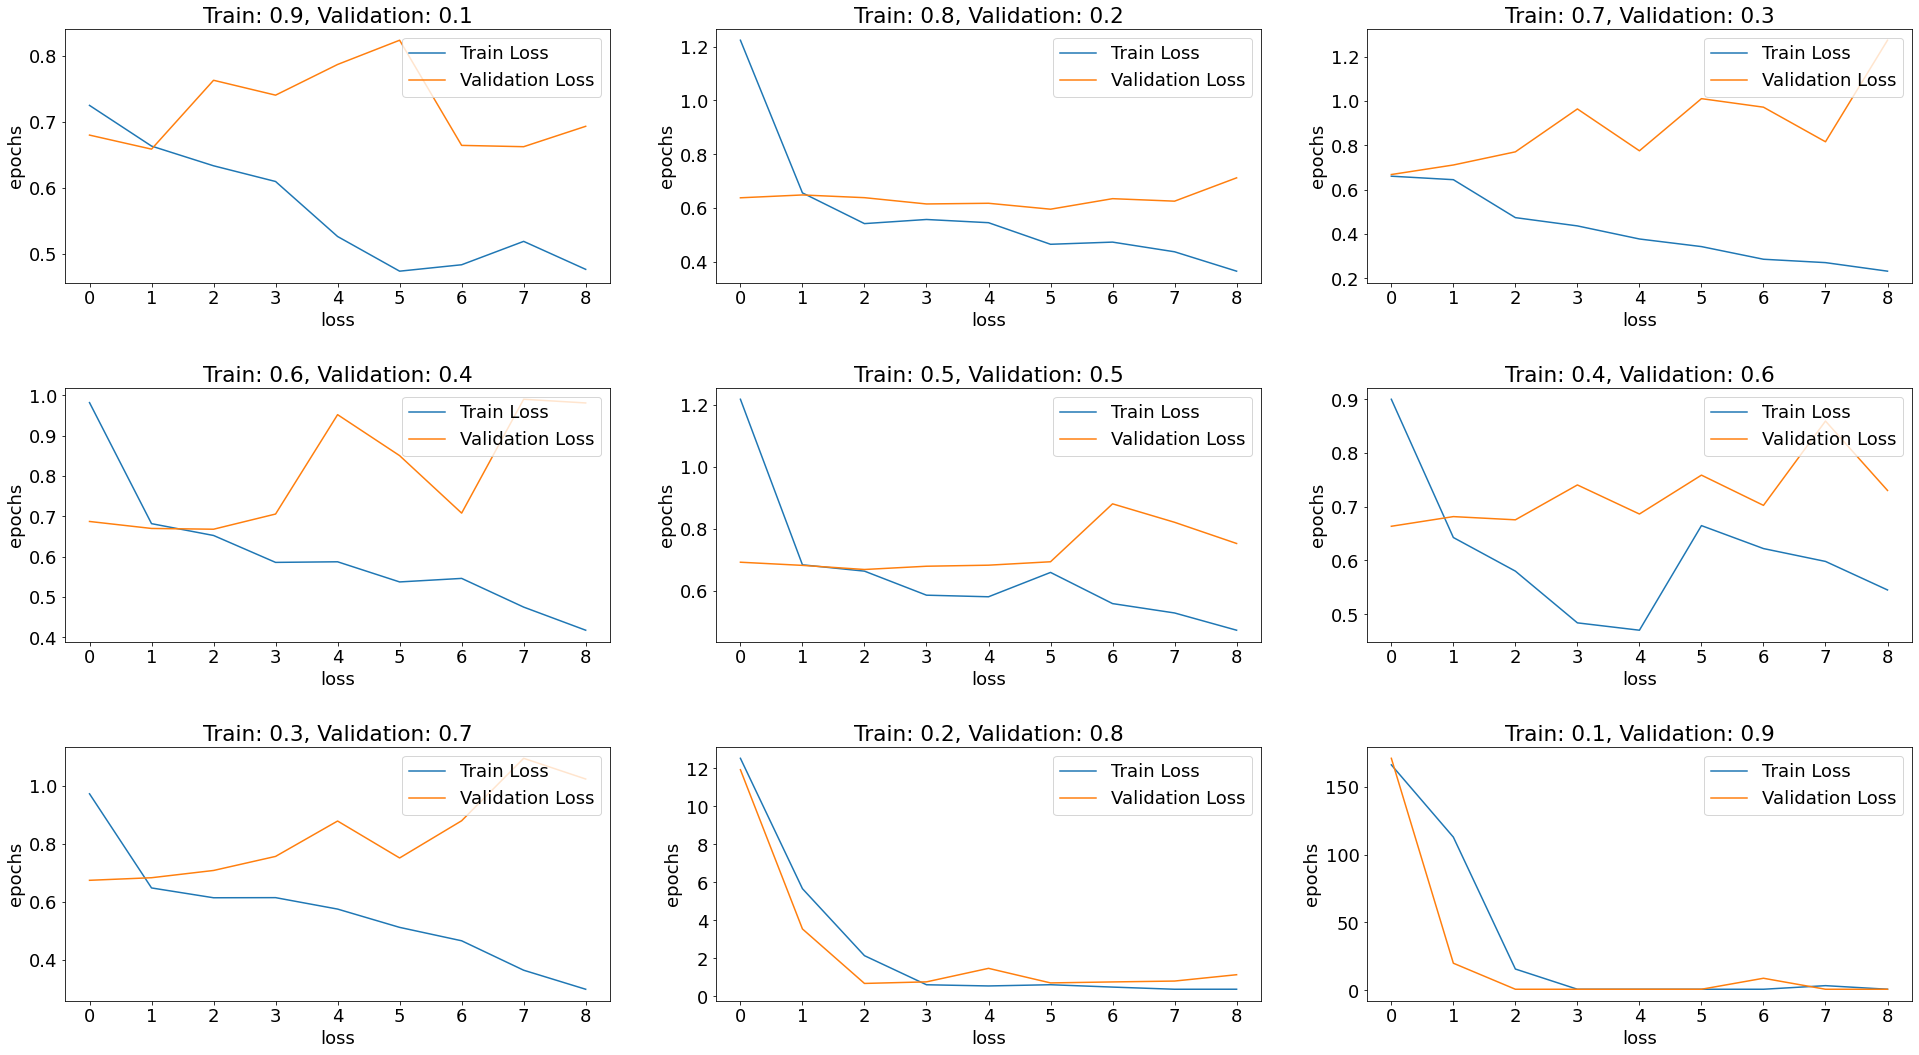

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(27,15))
plt.rcParams.update({'font.size': 18})
for i in range(3):
    ratio = round(0.1*(i+1), 2)
    train_ds, valid_ds = get_train_data(
        validation_split_ratio=ratio,
        data_dir="./1_data/exp"
    )
    model = Model()
    callback = model.fit(train_ds, valid_ds)
    ax = plt.subplot(3, 3, i+1)
    ax.plot(callback.history['loss'][1:], label='Train Loss')
    ax.plot(callback.history['val_loss'][1:], label='Validation Loss')
    ax.title.set_text(f"Train: {round(1-ratio, 2)}, Validation: {ratio}")
    ax.set(xlabel="epochs", ylabel="loss")
    ax.legend(loc='upper right')

plt.tight_layout(h_pad=2, w_pad=2)
plt.show()